In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os

#sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [3]:
import explore
import plot
import clean

In [4]:
cleaned = clean.clean()

# Import The Data

In [5]:
# Data that contains information about the completed orders

data_url = explore.get_data_url("data/nb.csv", "v0")
df_CompleteOrders = pd.read_csv(data_url)

In [6]:
print("completed orders data has {} rows and {} columns".format(df_CompleteOrders.shape[0], df_CompleteOrders.shape[1]))

completed orders data has 536020 rows and 5 columns


In [7]:
df_CompleteOrders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Trip ID           536020 non-null  int64 
 1   Trip Origin       536020 non-null  object
 2   Trip Destination  536020 non-null  object
 3   Trip Start Time   534369 non-null  object
 4   Trip End Time     536019 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.4+ MB


In [8]:
# able that contains delivery requests by clients (completed and unfulfilled) and driver locations during request

data_url = explore.get_data_url("data/driver_locations_during_request.csv", "v0")
df_driversloc = pd.read_csv(data_url)

In [9]:
print("driver locations during request data has {} rows and {} columns".format(df_driversloc.shape[0], df_driversloc.shape[1]))

driver locations during request data has 1557740 rows and 8 columns


In [10]:
df_driversloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


# Missing Values

In [11]:
explore.missing_values_table(df_CompleteOrders)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Trip Start Time,1651,0.3,object
Trip End Time,1,0.0,object


In [12]:
# missing values are small percentabe. We drop them
df_CompleteOrders.dropna(inplace= True)
explore.missing_values_table(df_CompleteOrders)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [13]:
# some values for 'Trip Origin' and 'Trip Destination' contain '1,1' which seem like a filler value

filler_inx = (df_CompleteOrders['Trip Origin']=='1,1')|(df_CompleteOrders['Trip Destination']=='1,1')

x = len(df_CompleteOrders[filler_inx])

print("coordinates value that are filled by '1,1' are {}, which is {:.2f}% of total values".format(x, x/len(df_CompleteOrders)))

coordinates value that are filled by '1,1' are 62, which is 0.00% of total values


In [14]:
# we can drop these values

df_CompleteOrders.drop(df_CompleteOrders[filler_inx].index, inplace= True)

In [15]:
explore.missing_values_table(df_driversloc)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values,Dtype
created_at,1557740,100.0,float64
updated_at,1557740,100.0,float64


In [16]:
# two columns are empty. we drop them

df_driversloc.dropna(axis=1, inplace=True)
explore.missing_values_table(df_driversloc)

Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


# Data Overview

We take a look at the data. Types of variables and calculate basic statistics

### 1. Data on fulfilled Orders

In [17]:
df_CompleteOrders.dtypes

Trip ID              int64
Trip Origin         object
Trip Destination    object
Trip Start Time     object
Trip End Time       object
dtype: object

In [18]:
# Trip ID should all be unique values

df_CompleteOrders['Trip ID'].nunique() == df_CompleteOrders.shape[0]

True

In [19]:
# We change the type of 
# 1. Time variables to datetime 
# 2. Origin and Destinations from strings to latitude and longitude


clean_orders = pd.DataFrame()

clean_orders['trip_id'] = df_CompleteOrders['Trip ID']

# change to datetime
clean_orders['trip_start_time'] = pd.to_datetime(df_CompleteOrders['Trip Start Time'])
clean_orders['trip_end_time'] = pd.to_datetime(df_CompleteOrders['Trip End Time'])

# split into latitude longitude
clean_orders['origin_lat'] = df_CompleteOrders['Trip Origin'].apply(lambda x: float(x.split(',')[0]))
clean_orders['origin_long'] = df_CompleteOrders['Trip Origin'].apply(lambda x: float(x.split(',')[1]))

clean_orders['destination_lat'] = df_CompleteOrders['Trip Destination'].apply(lambda x: float(x.split(',')[0]))
clean_orders['destination_long'] = df_CompleteOrders['Trip Destination'].apply(lambda x: float(x.split(',')[1]))

In [20]:
clean_orders.describe()

,trip_id,origin_lat,origin_long,destination_lat,destination_long
count,5.343060e+05,534306.000000,534306.000000,534306.000000,534306.000000
mean,9.901071e+05,6.528513,3.397394,6.523700,3.407750
std,3.454163e+05,0.091202,0.087272,0.093356,0.099802
min,3.919960e+05,4.859346,2.877515,4.812808,-0.293233
25%,6.929912e+05,6.450964,3.345037,6.447909,3.346085
50%,9.898230e+05,6.519571,3.374900,6.507310,3.382388
75%,1.279748e+06,6.594634,3.456603,6.593282,3.473291
max,1.637709e+06,9.218182,8.522293,9.056223,8.607887


In [21]:
print("Data on fulfilled orders spans the period from {} to {}".format(clean_orders['trip_start_time'].min(), clean_orders['trip_start_time'].max()))

Data on fulfilled orders spans the period from 2021-07-01 06:21:02 to 2022-06-13 10:04:28


### 2. Data on Drivers Locations

In [22]:
# The column 'id' doesn't seem to indicate anything aside from being a simple index

df_driversloc['id'].unique()

array([      1,       2,       3, ..., 1557738, 1557739, 1557740])

In [23]:
# dropping the column 'id' reveal that the data have duplicates

clean_driversloc = df_driversloc.drop(columns=['id']).drop_duplicates()

clean_driversloc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718826 entries, 0 to 1557731
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       718826 non-null  int64  
 1   driver_id      718826 non-null  int64  
 2   driver_action  718826 non-null  object 
 3   lat            718826 non-null  float64
 4   lng            718826 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 32.9+ MB


In [24]:
print("{:.2f}% of drivers data was duplicated.".format(1-len(clean_driversloc)/len(df_driversloc)))

0.54% of drivers data was duplicated.


# Calculate Trips' distances and time durations

## 1. Clean Up latitude and Longitude Data

- First we import geopy to handle coordinates
- Second compare location data to expected values in Lagos, Nigeria

In [25]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

boundingbox is a comma separated list of min latitude, max latitude, min longitude, max longitude [see reference](https://nominatim.org/release-docs/develop/api/Output/#boundingbox)

In [26]:
location = geolocator.geocode("Lagos")

lagos_bbox = location.raw['boundingbox']

print("Locations within Lagos-Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*lagos_bbox))



location = geolocator.geocode("Nigeria")

nigeria_bbox = location.raw['boundingbox']

print("\nLocations within Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*nigeria_bbox))


Locations within Lagos-Nigeria are bounded by these values:
latidude: 6.2950575 - 6.6150575 
longitude: 3.2341795 - 3.5541795

Locations within Nigeria are bounded by these values:
latidude: 4.0690959 - 13.885645 
longitude: 2.676932 - 14.678014


Bounds for Lagos-Nigeria should represent soft bounds for our data. We expect locations to be more or less within Lagos bounds.

Hard bounds are represented by bounds for the country of Nigeria. No correct value can exceed these bounds

In [28]:
# We drop trips whose coordinate fall out of Nigeria boundingbox

print("For coordinates of trip origin:")
clean_orders = cleaned.out_bounds(clean_orders, 'origin_lat', 'origin_long', nigeria_bbox, drop=True)

print("For coordinates of trip destination:")
clean_orders = cleaned.out_bounds(clean_orders, 'destination_lat', 'destination_long', nigeria_bbox, drop=True)

For coordinates of trip origin:
There are 0 coordinate values out of bounds, accounting to 0.00% of records.
For coordinates of trip destination:
There are 1 coordinate values out of bounds, accounting to 0.00% of records.


In [29]:
# Trips whose coordinates fall out of Lagos boundingbox

print("For coordinates of trip origin:")
clean_orders = cleaned.out_bounds(clean_orders, 'origin_lat', 'origin_long', lagos_bbox, drop=False)

print("For coordinates of trip destination:")
clean_orders = cleaned.out_bounds(clean_orders, 'destination_lat', 'destination_long', lagos_bbox, drop=False)

For coordinates of trip origin:
There are 98891 coordinate values out of bounds, accounting to 0.19% of records.
For coordinates of trip destination:
There are 118894 coordinate values out of bounds, accounting to 0.22% of records.


0.35% of Orders come or go to locations outside of Lagos.

In [30]:
# Dirvers whose locations at requests fall out of Nigeria boundingbox

clean_driversloc = cleaned.out_bounds(clean_driversloc , 'lat', 'lng', nigeria_bbox, drop=False)

There are 0 coordinate values out of bounds, accounting to 0.00% of records.


In [31]:
# Dirvers whose locations at requests fall out of Lagos boundingbox

clean_driversloc = cleaned.out_bounds(clean_driversloc , 'lat', 'lng', lagos_bbox, drop=False)

There are 64028 coordinate values out of bounds, accounting to 0.09% of records.


## 2. Calculate Trips' Durations

In [32]:
clean_orders['trip_duration'] = clean_orders['trip_end_time']- clean_orders['trip_start_time']

# trip duration in hours 
clean_orders['trip_duration_hrs'] = clean_orders['trip_duration'].apply(lambda x: x.seconds/60/60)

In [33]:
clean_orders['trip_duration_hrs'].describe()

count    534305.000000
mean          1.189908
std           1.692039
min           0.000000
25%           0.561389
50%           0.882222
75%           1.335000
max          23.996389
Name: trip_duration_hrs, dtype: float64

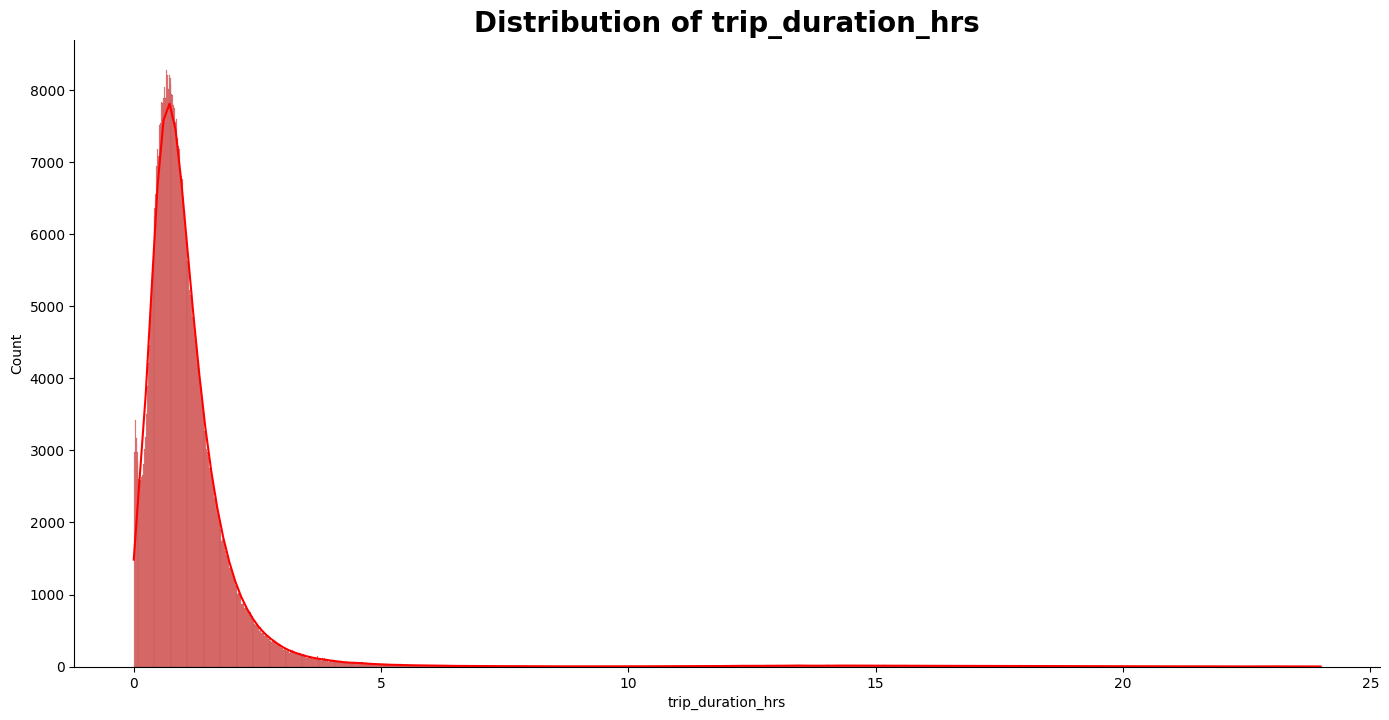

In [31]:
plot.plot_hist(clean_orders,'trip_duration_hrs', 'red')

There are trips whose duration is too short (less than 5 minutes). Could be that these trips were cancelled

In [34]:
df = clean_orders[clean_orders['trip_duration_hrs']<5/60]

print("{} trips have a duration less than 5 minutes, accounting to {:.2f}% of all orders.".format(len(df), len(df)/len(clean_orders)))

13573 trips have a duration less than 5 minutes, accounting to 0.03% of all orders.


## 3. Calculate Trip Distances

Since we have latitude-longitude for starting point and end point. we calculate the straight line distance and not the actual distance traveled along roads.

- we use geopy liberary for calculating distances from lat-long values

- Geopy can calculate geodesic distance between two points using the geodesic distance or the great-circle distance, with a default of the geodesic distance available as the function

In [35]:
from geopy import distance

In [36]:
clean_orders['distance_km'] = clean_orders.apply(lambda x: distance.distance((x['origin_lat'], x['origin_long']),
(x['destination_lat'], x['destination_long'])).km, axis=1)

In [37]:
clean_orders['distance_km'].describe()

count    534305.000000
mean         12.023147
std           8.451186
min           0.000000
25%           5.559767
50%          10.509524
75%          16.992917
max         533.747902
Name: distance_km, dtype: float64

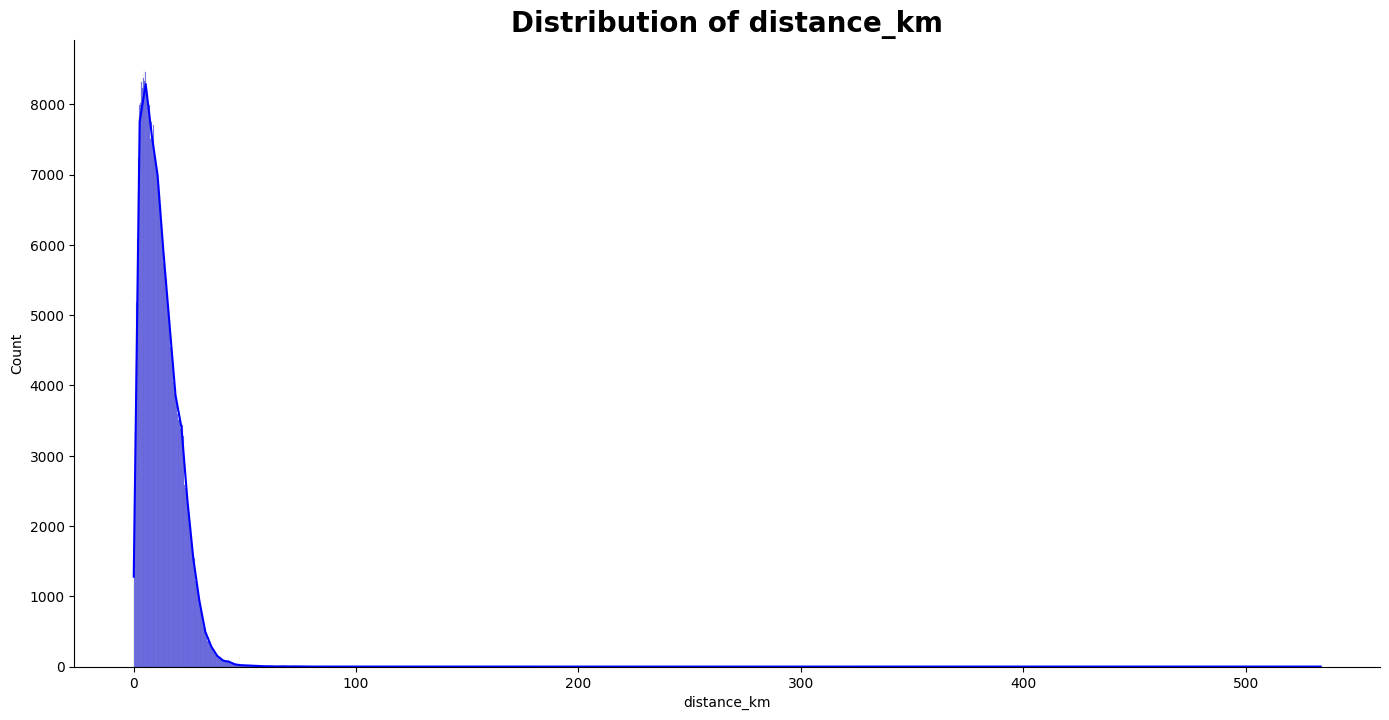

In [40]:
plot.plot_hist(clean_orders,'distance_km', 'blue')

In [38]:
df = clean_orders[clean_orders['distance_km']< 0.1]

print("{} trips of less than 100 meters, accounting to {:.2f}% of all orders.".format(len(df), len(df)/len(clean_orders)))

617 trips of less than 100 meters, accounting to 0.00% of all orders.


# How many drivers Per Order?

We look at the data of drivers, to answer the questions:

- how many drivers are notified per order?
- how many drivers accept or reject per order?

In [126]:
print("full number of records is ", len(clean_driversloc))

x = clean_driversloc[['order_id', 'driver_id']].drop_duplicates()

print("However, there are only {} unique pairs of order_id & driver_id".format(len(x)))

full number of records is  718826
However, there are only 611799 unique pairs of order_id & driver_id


We make a couple of observations:

- The combination of 'order_id' + 'driver_id' almost identifies the table of driver location. Although there are cases where the are repeated:

  - There are drivers that have both 'accepted' and 'rejected' actions regarding the same order. These cases could be of a driver that accepted then rejected the order.

- Related, there are orders that get accepted by more than 1 driver. These cases could be that the first driver rejected, so another driver got to accept.

In [109]:
df = pd.DataFrame()

df['order_id'] = clean_driversloc['order_id']

df['driver_id'] = clean_driversloc['driver_id']

df.drop_duplicates(inplace= True)


drivers_per_orders = df.groupby('order_id').count()

drivers_per_orders.rename(columns={'driver_id': 'num_drivers'}, inplace=True)

In [110]:
drivers_per_orders.describe()

,num_drivers
count,26492.000000
mean,23.093726
std,21.222153
min,1.000000
25%,8.000000
50%,17.000000
75%,30.000000
max,215.000000


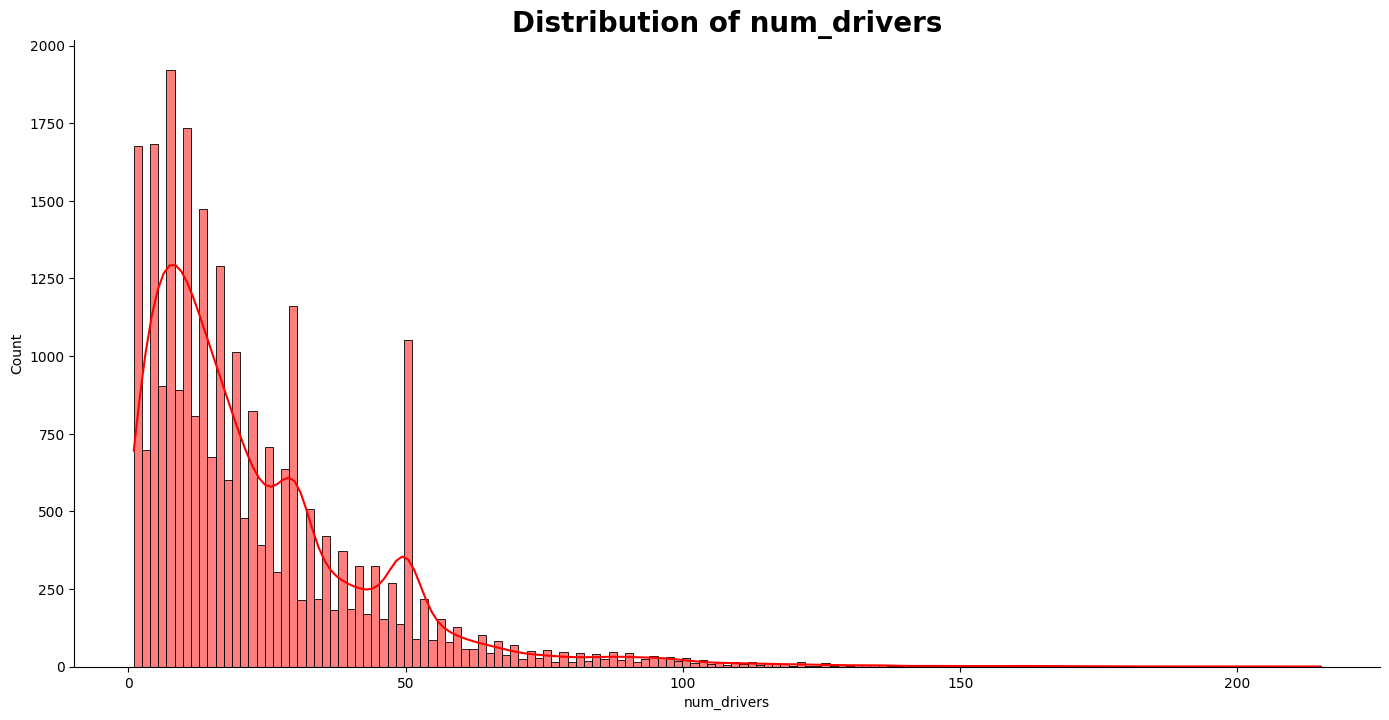

In [113]:
plot.plot_hist(drivers_per_orders, 'num_drivers', 'red')

In [131]:
df = pd.DataFrame()

df['order_id'] = clean_driversloc['order_id']

df['driver_id'] = clean_driversloc['driver_id']

df['accepted'] = clean_driversloc['driver_action'].apply(lambda x: 1 if x == 'accepted' else 0)

df['rejected'] = clean_driversloc['driver_action'].apply(lambda x: 1 if x == 'rejected' else 0)



sorted_drivers_per_order = df.groupby('order_id').agg({'accepted': 'sum', 'rejected': 'sum'})

In [132]:
sorted_drivers_per_order.describe()

,accepted,rejected
count,26492.000000,26492.000000
mean,0.977767,26.155934
std,0.152972,29.919345
min,0.000000,0.000000
25%,1.000000,8.000000
50%,1.000000,17.000000
75%,1.000000,34.000000
max,2.000000,499.000000


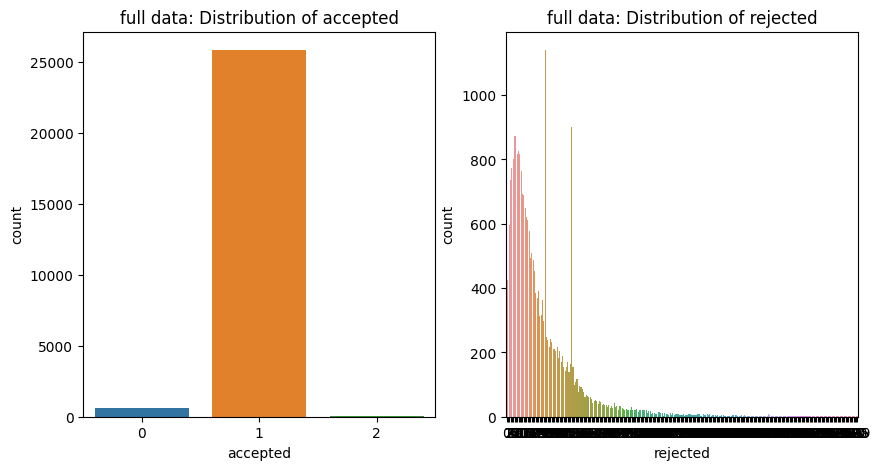

In [134]:
_, axes = plt.subplots(1,2, figsize= (10,5), sharey= True)

plot.plot_hist_compare(axes[0], sorted_drivers_per_order, 'accepted', 'red')
plot.plot_hist_compare(axes[1], sorted_drivers_per_order, 'rejected', 'blue')

# Merge order and drivers-location dataframes

We need to merge the two dataframes of fulfilled orders and dirvers locations at request to answer questions like:

- how many drivers are notified for each rquest?
- How far are the Drivers at request?

In [46]:
clean_orders.rename(columns={'distance_km': 'trip_distance_km'}, inplace=True)

clean_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534305 entries, 0 to 536019
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   trip_id            534305 non-null  int64          
 1   trip_start_time    534305 non-null  datetime64[ns] 
 2   trip_end_time      534305 non-null  datetime64[ns] 
 3   origin_lat         534305 non-null  float64        
 4   origin_long        534305 non-null  float64        
 5   destination_lat    534305 non-null  float64        
 6   destination_long   534305 non-null  float64        
 7   trip_duration      534305 non-null  timedelta64[ns]
 8   trip_duration_hrs  534305 non-null  float64        
 9   trip_distance_km   534305 non-null  float64        
dtypes: datetime64[ns](2), float64(6), int64(1), timedelta64[ns](1)
memory usage: 61.0 MB


In [47]:
df_driversloc.rename(columns={'lat': 'driver_lat', 'lng': 'driver_lng'}, inplace=True)
df_driversloc.drop(columns=['id'], inplace=True)

df_driversloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   order_id       1557740 non-null  int64  
 1   driver_id      1557740 non-null  int64  
 2   driver_action  1557740 non-null  object 
 3   driver_lat     1557740 non-null  float64
 4   driver_lng     1557740 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 59.4+ MB


In [48]:
df_merged = pd.merge(clean_orders, df_driversloc, how= 'inner', left_on= 'trip_id', right_on= 'order_id')

In [58]:
df_merged.drop(columns=['order_id'], inplace= True)

df_merged.rename(columns={'trip_id': 'order_id'}, inplace= True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1555708 entries, 0 to 1555707
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype          
---  ------             --------------    -----          
 0   order_id           1555708 non-null  int64          
 1   trip_start_time    1555708 non-null  datetime64[ns] 
 2   trip_end_time      1555708 non-null  datetime64[ns] 
 3   origin_lat         1555708 non-null  float64        
 4   origin_long        1555708 non-null  float64        
 5   destination_lat    1555708 non-null  float64        
 6   destination_long   1555708 non-null  float64        
 7   trip_duration      1555708 non-null  timedelta64[ns]
 8   trip_duration_hrs  1555708 non-null  float64        
 9   trip_distance_km   1555708 non-null  float64        
 10  driver_id          1555708 non-null  int64          
 11  driver_action      1555708 non-null  object         
 12  driver_lat         1555708 non-null  float64        
 13  driver_lng  

In [ ]:
df = pd.DataFrame()

df['order_id'] = df_merged['order_id']